# Introduction
Manual for the preparation and use of the Deep Learning model for battery SoH prediction
This Python Notebook shows and analyzes how the battery charge / discharge dataset obtained from NASA should be treated. It also shows how the model proposed by [1] and [2] is prepared and its encoding necessary to be used.

Requirements
For the training phase of this model it is necessary to have Python 3.x installed along with the following libraries:

Tensorflow 2.0
Numpy
Pandas
Scipy
Sci-kit learn
Matplot
Seaborn
For the prediction phase of this model it is necessary to have the same libraries with the exception of Matplot and Seaborn

Dataset preparation
Since this manual was created from Google Colab (this may not be necessary to do it in an offline environment), it is necessary to download the dataset and then unzip it in a specific directory.

In [1]:
%config Completer.use_jedi = False

In [2]:
%matplotlib inline
!pip show tensorflow

# Library import
In this part, all the necessary libraries for the treatment of the dataset are important.

In [3]:
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

# Loading the dataset into memory
According to the README of the dataset, the data is stored in several ".mat" files, each file corresponds to a specific battery and the data structure of each file is as follows:

```
Data Structure:
cycle:	top level structure array containing the charge, discharge and impedance operations
	type: 	operation  type, can be charge, discharge or impedance
	ambient_temperature:	ambient temperature (degree C)
	time: 	the date and time of the start of the cycle, in MATLAB  date vector format
	data:	data structure containing the measurements
	   for charge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at charger (Amps)
		Voltage_charge:		Voltage measured at charger (Volts)
		Time:			Time vector for the cycle (secs)
	   for discharge the fields are:
		Voltage_measured: 	Battery terminal voltage (Volts)
		Current_measured:	Battery output current (Amps)
		Temperature_measured: 	Battery temperature (degree C)
		Current_charge:		Current measured at load (Amps)
		Voltage_charge:		Voltage measured at load (Volts)
		Time:			Time vector for the cycle (secs)
		Capacity:		Battery capacity (Ahr) for discharge till 2.7V 
	   for impedance the fields are:
		Sense_current:		Current in sense branch (Amps)
		Battery_current:	Current in battery branch (Amps)
		Current_ratio:		Ratio of the above currents 
		Battery_impedance:	Battery impedance (Ohms) computed from raw data
		Rectified_impedance:	Calibrated and smoothed battery impedance (Ohms) 
		Re:			Estimated electrolyte resistance (Ohms)
		Rct:			Estimated charge transfer resistance (Ohms)

```

For the Deep Learning model proposed in [1] it is only necessary to collect the data related to the discharge of the battery, for this a function is created in Python that is in charge of reading this data from the ".mat" file and storing it in memory in two pandas DataFrame for later access. After loading the dataset, a description of the data is made using panda functions to verify if the data loading was correct.

In [5]:
def load_data(battery):
  mat = loadmat('NASA/' + battery + '.mat')
  print('Total data in dataset: ', len(mat[battery][0, 0]['cycle'][0]))
  counter = 0
  dataset = []
  capacity_data = []
  
  for i in range(len(mat[battery][0, 0]['cycle'][0])):
    row = mat[battery][0, 0]['cycle'][0, i]
    if row['type'][0] == 'discharge':
      ambient_temperature = row['ambient_temperature'][0][0]
      date_time = datetime.datetime(int(row['time'][0][0]),
                               int(row['time'][0][1]),
                               int(row['time'][0][2]),
                               int(row['time'][0][3]),
                               int(row['time'][0][4])) + datetime.timedelta(seconds=int(row['time'][0][5]))
      data = row['data']
      capacity = data[0][0]['Capacity'][0][0]
      for j in range(len(data[0][0]['Voltage_measured'][0])):
        voltage_measured = data[0][0]['Voltage_measured'][0][j]
        current_measured = data[0][0]['Current_measured'][0][j]
        temperature_measured = data[0][0]['Temperature_measured'][0][j]
        current_load = data[0][0]['Current_load'][0][j]
        voltage_load = data[0][0]['Voltage_load'][0][j]
        time = data[0][0]['Time'][0][j]
        dataset.append([counter + 1, ambient_temperature, date_time, capacity,
                        voltage_measured, current_measured,
                        temperature_measured, current_load,
                        voltage_load, time])
      capacity_data.append([counter + 1, ambient_temperature, date_time, capacity])
      counter = counter + 1
  print(dataset[0])
  return [pd.DataFrame(data=dataset,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity', 'voltage_measured',
                                'current_measured', 'temperature_measured',
                                'current_load', 'voltage_load', 'time']),
          pd.DataFrame(data=capacity_data,
                       columns=['cycle', 'ambient_temperature', 'datetime',
                                'capacity'])]
dataset, capacity = load_data('B0005')
pd.set_option('display.max_columns', 10)
print(dataset.head())
dataset.describe()

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  1.856487          4.191492   
1      1                   24 2008-04-02 15:25:41  1.856487          4.190749   
2      1                   24 2008-04-02 15:25:41  1.856487          3.974871   
3      1                   24 2008-04-02 15:25:41  1.856487          3.951717   
4      1                   24 2008-04-02 15:25:41  1.856487          3.934352   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.004902             24.330034       -0.0006         0.000   0.000  
1         -0.001478             24.325993       -0.0006         4.206  16.781  
2         -2.012528             24.389085       -1.9982         3.062  35.703  
3         -2.

,cycle,ambient_temperature,datetime,capacity,voltage_measured,current_measured,temperature_measured,current_load,voltage_load,time
count,50285.000000,50285.0,50285,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000,50285.000000
mean,88.125942,24.0,2008-05-07 01:58:43.570826240,1.560345,3.515268,-1.806032,32.816991,1.362700,2.308406,1546.208924
min,1.000000,24.0,2008-04-02 15:25:41,1.287453,2.455679,-2.029098,23.214802,-1.998400,0.000000,0.000000
25%,50.000000,24.0,2008-04-29 22:00:04,1.386229,3.399384,-2.013415,30.019392,1.998000,2.388000,768.563000
50%,88.000000,24.0,2008-05-07 21:56:09,1.538237,3.511664,-2.012312,32.828944,1.998200,2.533000,1537.031000
75%,127.000000,24.0,2008-05-18 03:05:19,1.746871,3.660903,-2.011052,35.920887,1.998200,2.690000,2305.984000
max,168.000000,24.0,2008-05-27 20:45:42,1.856487,4.222920,0.007496,41.450232,1.998400,4.238000,3690.234000
std,45.699687,0.0,NaN,0.182380,0.231778,0.610502,3.987515,1.313698,0.800300,906.640295


The following graph shows the aging process of the battery as the charge cycles progress. The horizontal line represents the threshold related to what can be considered the end of the battery's life cycle.

Text(0.5, 1.0, 'Discharge B0005')

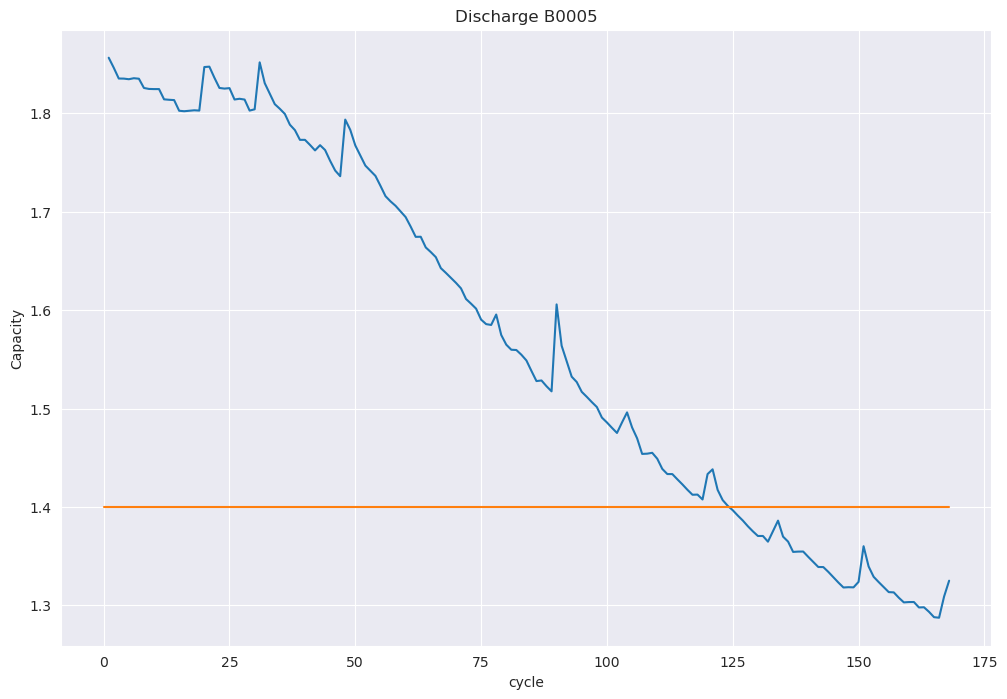

In [6]:
plot_df = capacity.loc[(capacity['cycle']>=1),['cycle','capacity']]
sns.set_style("darkgrid")
plt.figure(figsize=(12, 8))
plt.plot(plot_df['cycle'], plot_df['capacity'])
#Draw threshold
plt.plot([0.,len(capacity)], [1.4, 1.4])
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

It is also necessary to calculate the SoH of the battery, since this is the data that will be predicted using the * deep learning * model.

In [7]:
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity'])/C
print(dis_ele.head(5))

   cycle            datetime  capacity       SoH
0      1 2008-04-02 15:25:41  1.856487  1.000000
1      2 2008-04-02 19:43:48  1.846327  0.994527
2      3 2008-04-03 00:01:06  1.835349  0.988614
3      4 2008-04-03 04:16:37  1.835263  0.988567
4      5 2008-04-03 08:33:25  1.834646  0.988235


Similarly to what has been done previously, a graph of the SoH is made for each cycle, the horizontal line represents the threshold of 70% in which the battery already fulfills its life cycle and it is advisable to make the change.

Text(0.5, 1.0, 'Discharge B0005')

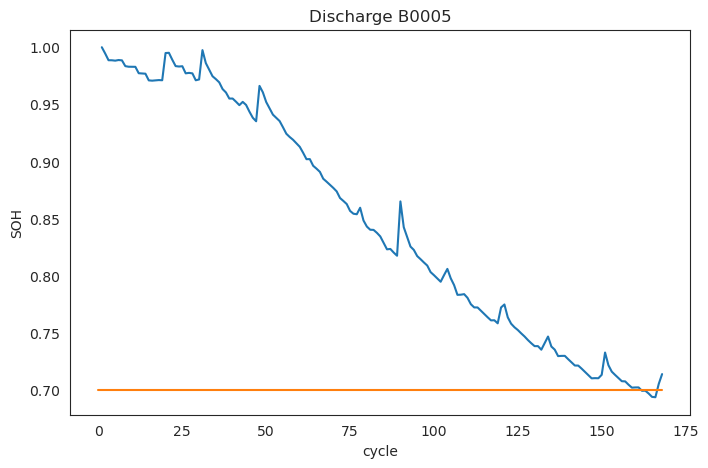

In [8]:
plot_df = dis_ele.loc[(dis_ele['cycle']>=1),['cycle','SoH']]
sns.set_style("white")
plt.figure(figsize=(8, 5))
plt.plot(plot_df['cycle'], plot_df['SoH'])
#Draw threshold
plt.plot([0.,len(capacity)], [0.70, 0.70])
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.title('Discharge B0005')

# Training phase for calculating SoH
The dataset is prepared in such a way that it can be used by Tensorflow in the training phase, for this, two structures are created corresponding to the input and output expected to be obtained. For the input data, the relevant characteristics of the dataset are filtered, which are:

* Battery capacity
* Voltage
* Current
* Temperature
* Charging voltage
* Charging current
* Instant of time (from the start of the download)

For the output data, the SoH of the battery is calculated and in both input and output cases, the values are normalized to a range of values between [0-1].

In [9]:
C = dataset['capacity'][0]
soh = []
for i in range(len(dataset)):
  soh.append([dataset['capacity'][i] / C])
soh = pd.DataFrame(data=soh, columns=['SoH'])

attribs=['capacity', 'voltage_measured', 'current_measured',
         'temperature_measured', 'current_load', 'voltage_load', 'time']
train_dataset = dataset[attribs]
sc = MinMaxScaler(feature_range=(0,1))
train_dataset = sc.fit_transform(train_dataset)
print(train_dataset.shape)
print(soh.shape)

(50285, 7)
(50285, 1)


Preparation of the model, 3 dense layers are used, and the parameters are used as they are in the paper: 3 dense layers and one dropout, and one of the ADAM type is used as optimizer

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

ModuleNotFoundError: No module named 'tensorflow'

In [10]:
model = Sequential()
model.add(Dense(8, activation='relu', input_dim=train_dataset.shape[1]))
model.add(Dense(8, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dropout(rate=0.25))
model.add(Dense(1))
model.summary()
model.compile(optimizer=Adam(beta_1=0.9, beta_2=0.999, epsilon=1e-08), loss='mean_absolute_error')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 8)                 64        
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 72        
_________________________________________________________________
dropout (Dropout)            (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 217
Trainable params: 217
Non-trainable params: 0
_________________________________________________________________


## The model is trained, 50 epochs are used for training

In [11]:
model.fit(x=train_dataset, y=soh.to_numpy(), batch_size=25, epochs=50)

Epoch 1/50
2012/2012 [==============================] - 3s 1ms/step - loss: 0.2121
Epoch 2/50
2012/2012 [==============================] - 2s 1ms/step - loss: 0.0290
Epoch 3/50
2012/2012 [==============================] - 2s 1ms/step - loss: 0.0285
Epoch 4/50
2012/2012 [==============================] - 2s 1ms/step - loss: 0.0225
Epoch 5/50
2012/2012 [==============================] - 2s 1ms/step - loss: 0.0212
Epoch 6/50
2012/2012 [==============================] - 2s 1ms/step - loss: 0.0203
Epoch 7/50
2012/2012 [==============================] - 2s 1ms/step - loss: 0.0201
Epoch 8/50
2012/2012 [==============================] - 2s 1ms/step - loss: 0.0207
Epoch 9/50
2012/2012 [==============================] - 2s 1ms/step - loss: 0.0203
Epoch 10/50
2012/2012 [==============================] - 2s 1ms/step - loss: 0.0204
Epoch 11/50
2012/2012 [==============================] - 2s 990us/step - loss: 0.0207
Epoch 12/50
2012/2012 [==============================] - 2s 1ms/step - loss: 0.0205

# Testing to test the SoH prediction model
To test the correctness of the model, the information of the same battery is loaded (B0006)

In [12]:
dataset_val, capacity_val = load_data('B0006')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
C = dis_ele['capacity'][0]
for i in range(len(dis_ele)):
    dis_ele['SoH']=(dis_ele['capacity']) / C
print(dataset_val.head(5))
print(dis_ele.head(5))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 2.035337591005598, 4.179799607333447, -0.0023663271409738672, 24.277567510331888, -0.0006, 0.0, 0.0]
   cycle  ambient_temperature            datetime  capacity  voltage_measured  \
0      1                   24 2008-04-02 15:25:41  2.035338          4.179800   
1      1                   24 2008-04-02 15:25:41  2.035338          4.179823   
2      1                   24 2008-04-02 15:25:41  2.035338          3.966528   
3      1                   24 2008-04-02 15:25:41  2.035338          3.945886   
4      1                   24 2008-04-02 15:25:41  2.035338          3.930354   

   current_measured  temperature_measured  current_load  voltage_load    time  
0         -0.002366             24.277568       -0.0006         0.000   0.000  
1          0.000434             24.277073       -0.0006         4.195  16.781  
2         -2.014242             24.366226       -1.9990         3.070  35.703  
3         -2.

A table is created containing the real SoH and the SoH predicted by the network and the root of the mean square error is calculated.

In [13]:
attrib=['capacity', 'voltage_measured', 'current_measured',
        'temperature_measured', 'current_load', 'voltage_load', 'time']
soh_pred = model.predict(sc.fit_transform(dataset_val[attrib]))
print(soh_pred.shape)

C = dataset_val['capacity'][0]
soh = []
for i in range(len(dataset_val)):
  soh.append(dataset_val['capacity'][i] / C)
new_soh = dataset_val.loc[(dataset_val['cycle'] >= 1), ['cycle']]
new_soh['SoH'] =  soh
new_soh['NewSoH'] = soh_pred
new_soh = new_soh.groupby(['cycle']).mean().reset_index()
print(new_soh.head(10))
rms = np.sqrt(mean_squared_error(new_soh['SoH'], new_soh['NewSoH']))
print('Root Mean Square Error: ', rms)

(50285, 1)
   cycle       SoH    NewSoH
0      1  1.000000  0.998882
1      2  0.994990  0.995428
2      3  0.989185  0.991381
3      4  0.989165  0.991373
4      5  0.982898  0.986936
5      6  0.989467  0.991528
6      7  0.989075  0.991262
7      8  0.967304  0.976103
8      9  0.966997  0.975897
9     10  0.961625  0.972082
Root Mean Square Error:  0.09069180316427912


Finally both SoH are plotted to observe their differences

Text(0.5, 1.0, 'Discharge B0006')

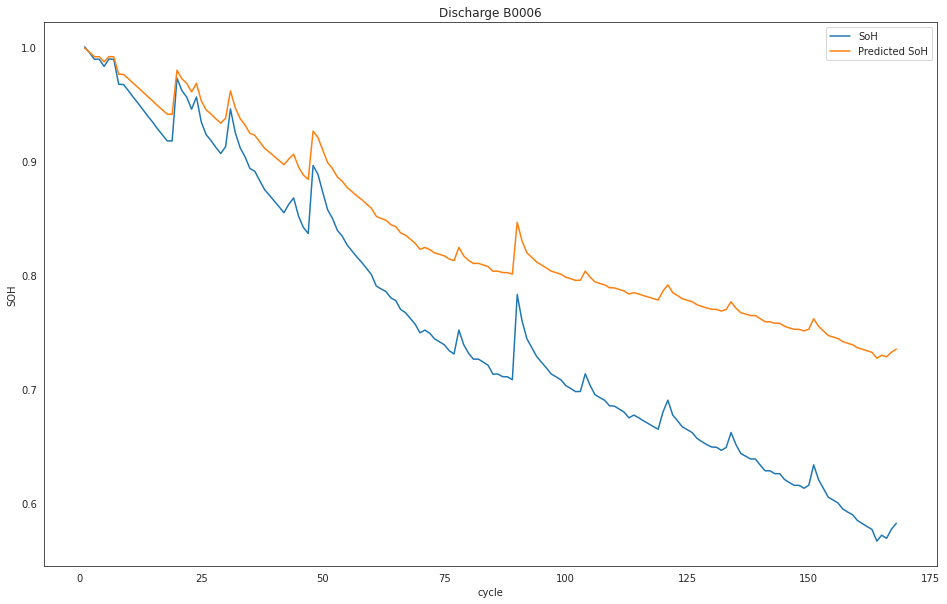

In [14]:
plot_df = new_soh.loc[(new_soh['cycle']>=1),['cycle','SoH', 'NewSoH']]
sns.set_style("white")
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['SoH'], label='SoH')
plt.plot(plot_df['cycle'], plot_df['NewSoH'], label='Predicted SoH')
#Draw threshold
#plt.plot([0.,len(capacity)], [0.70, 0.70], label='Threshold')
plt.ylabel('SOH')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0006')

For the estimation of SoH, it can be seen that the data pattern is learned by the model correctly, as predicted by the theory, since the shape of the curves is almost identical. The SoH shown has the same behavior as expected in theory, which is corroborated with the root mean square error value of the graph in illustration 8, whose value of 9% is very similar to that found previously. This reaffirms the precision when making the prediction.

# RUL estimation
In the same way that was done for the estimation of SoH, the training and testing dataset is prepared, in this particular case the battery capacity data is used using the first data of the first 50 cycles to predict the capacity in the following cycles in such a way as to be able to know when the threshold of the battery is reached and estimate the remaining cycles to reach the End of Life of the battery

In [15]:
dataset_val, capacity_val = load_data('B0005')
attrib=['cycle', 'datetime', 'capacity']
dis_ele = capacity_val[attrib]
rows=['cycle','capacity']
dataset=dis_ele[rows]
data_train=dataset[(dataset['cycle']<50)]
data_set_train=data_train.iloc[:,1:2].values
data_test=dataset[(dataset['cycle']>=50)]
data_set_test=data_test.iloc[:,1:2].values

sc=MinMaxScaler(feature_range=(0,1))
data_set_train=sc.fit_transform(data_set_train)
data_set_test=sc.transform(data_set_test)

X_train=[]
y_train=[]
#take the last 10t to predict 10t+1
for i in range(10,49):
    X_train.append(data_set_train[i-10:i,0])
    y_train.append(data_set_train[i,0])
X_train,y_train=np.array(X_train),np.array(y_train)
 
X_train=np.reshape(X_train,(X_train.shape[0],X_train.shape[1],1))

Total data in dataset:  616
[1, 24, datetime.datetime(2008, 4, 2, 15, 25, 41), 1.8564874208181574, 4.191491807505295, -0.004901589207462691, 24.330033885570543, -0.0006, 0.0, 0.0]


In this section the model is trained, based on the proposal of [2] and making use of LSTM-type networks instead of standard neural networks.

In [16]:
regress = Sequential()
regress.add(LSTM(units=200, return_sequences=True, input_shape=(X_train.shape[1],1)))
regress.add(Dropout(0.3))
regress.add(LSTM(units=200, return_sequences=True))
regress.add(Dropout(0.3))
regress.add(LSTM(units=200, return_sequences=True))
regress.add(Dropout(0.3))
regress.add(LSTM(units=200))
regress.add(Dropout(0.3))
regress.add(Dense(units=1))
regress.compile(optimizer='adam',loss='mean_squared_error')
regress.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 200)           161600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 200)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 200)           320800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 200)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 10, 200)           320800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 200)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 200)              

In [17]:
regress.fit(X_train,y_train,epochs=200,batch_size=25)

Epoch 1/200
2/2 [==============================] - 7s 66ms/step - loss: 0.3334
Epoch 2/200
2/2 [==============================] - 0s 61ms/step - loss: 0.1180
Epoch 3/200
2/2 [==============================] - 0s 61ms/step - loss: 0.1960
Epoch 4/200
2/2 [==============================] - 0s 57ms/step - loss: 0.0459
Epoch 5/200
2/2 [==============================] - 0s 60ms/step - loss: 0.0953
Epoch 6/200
2/2 [==============================] - 0s 59ms/step - loss: 0.1012
Epoch 7/200
2/2 [==============================] - 0s 58ms/step - loss: 0.0657
Epoch 8/200
2/2 [==============================] - 0s 57ms/step - loss: 0.0411
Epoch 9/200
2/2 [==============================] - 0s 62ms/step - loss: 0.0547
Epoch 10/200
2/2 [==============================] - 0s 56ms/step - loss: 0.0553
Epoch 11/200
2/2 [==============================] - 0s 59ms/step - loss: 0.0452
Epoch 12/200
2/2 [==============================] - 0s 58ms/step - loss: 0.0474
Epoch 13/200
2/2 [==============================]

In [18]:
print(len(data_test))
data_total=pd.concat((data_train['capacity'], data_test['capacity']),axis=0)
inputs=data_total[len(data_total)-len(data_test)-10:].values
inputs=inputs.reshape(-1,1)
inputs=sc.transform(inputs)

119


In [19]:
X_test=[]
for i in range(10,129):
    X_test.append(inputs[i-10:i,0])
X_test=np.array(X_test)
X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
pred=regress.predict(X_test)
print(pred.shape)
pred=sc.inverse_transform(pred)
pred=pred[:,0]
tests=data_test.iloc[:,1:2]
rmse = np.sqrt(mean_squared_error(tests, pred))
print('Test RMSE: %.3f' % rmse)
metrics.r2_score(tests,pred)

(119, 1)
Test RMSE: 0.100


0.45062570004829494

As can be seen, the mean RMSE is 0.05 (5%), which is very close to the values observed in the literature using this type of network.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

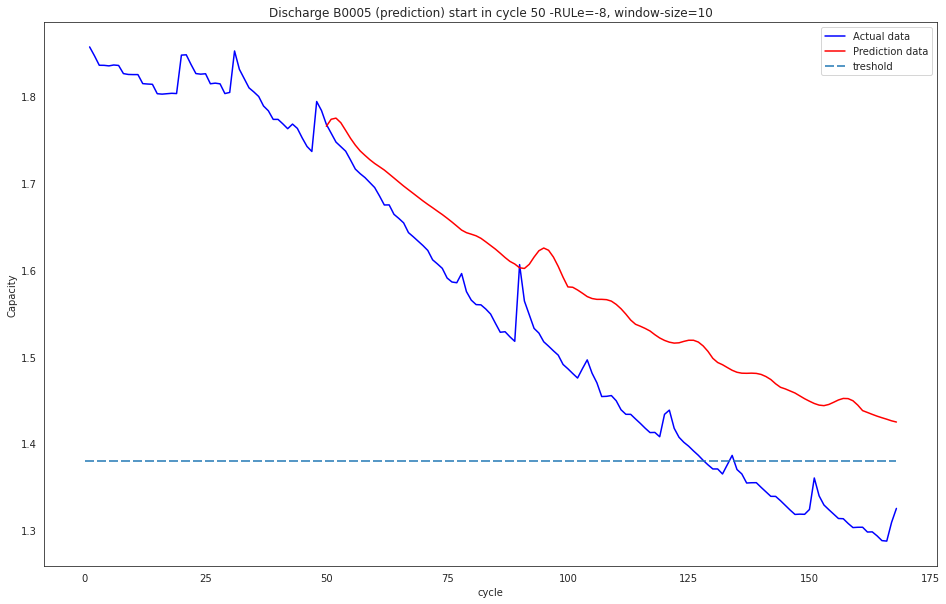

In [20]:
ln = len(data_train)
data_test['pre']=pred
plot_df = dataset.loc[(dataset['cycle']>=1),['cycle','capacity']]
plot_per = data_test.loc[(data_test['cycle']>=ln),['cycle','pre']]
plt.figure(figsize=(16, 10))
plt.plot(plot_df['cycle'], plot_df['capacity'], label="Actual data", color='blue')
plt.plot(plot_per['cycle'],plot_per['pre'],label="Prediction data", color='red')
#Draw threshold
plt.plot([0.,168], [1.38, 1.38],dashes=[6, 2], label="treshold")
plt.ylabel('Capacity')
# make x-axis ticks legible
adf = plt.gca().get_xaxis().get_major_formatter()
plt.xlabel('cycle')
plt.legend()
plt.title('Discharge B0005 (prediction) start in cycle 50 -RULe=-8, window-size=10')

Finally, it can be seen in the graph that the capacity value and how it behaves over time is very close to the real value and supporting these data, the error in the estimation of the RUL was -8 which makes us understand that The model went ahead by 8 cycles to estimate that the battery reached its end of life.

In [21]:
pred=0
Afil=0
Pfil=0
a=data_test['capacity'].values
b=data_test['pre'].values
j=0
k=0
for i in range(len(a)):
    actual=a[i]
    
    if actual<=1.38:
        j=i
        Afil=j
        break
for i in range(len(a)):
    pred=b[i]
    if pred< 1.38:
        k=i
        Pfil=k
        break
print("The Actual fail at cycle number: "+ str(Afil+ln))
print("The prediction fail at cycle number: "+ str(Pfil+ln))
RULerror=Pfil-Afil
print("The error of RUL= "+ str(RULerror)+ " Cycle(s)")

The Actual fail at cycle number: 128
The prediction fail at cycle number: 49
The error of RUL= -79 Cycle(s)
